In [31]:
"""
Get time-shifted cross-correlation between song and firing rates
"""

from analysis.parameters import peth_parm, freq_range, peth_parm, tick_length, tick_width, note_color, nb_note_crit
from analysis.spike import MotifInfo, AudioData
from database.load import DBInfo, ProjectLoader, create_db
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from util import save
from util.functions import myround
from util.draw import remove_right_top
import warnings

warnings.filterwarnings('ignore')

# SQL statement
# query = "SELECT * FROM cluster WHERE analysisOK = 1"
query = "SELECT * FROM cluster WHERE id = 34"

# Load database
db = ProjectLoader().load_db()
# SQL statement
db.execute(query)

In [32]:
cluster_db = DBInfo(db.cur.fetchall()[0])
name, path = cluster_db.load_cluster_db()
unit_nb = int(cluster_db.unit[-2:])
channel_nb = int(cluster_db.channel[-2:])
format = cluster_db.format
motif = cluster_db.motif

# Load class object
mi = MotifInfo(path, channel_nb, unit_nb, motif, format, name, update=update)  # cluster object
audio = AudioData(path, update=update)  # audio object


Load motif 034-w16w14-Predeafening-D18(20190615)-S02-Ch15-Cluster02


In [33]:
# parameters
rec_yloc = 0.05
rec_height = 1  # syllable duration rect
text_yloc = 0.5  # text height
font_size = 10
marker_size = 0.4  # for spike count
update = False
time_warp = True  # Perform piece-wise linear time-warping
motif_nb = 37

In [34]:
# Plot spectrogram & peri-event histogram (Just the first rendition)
# for onset, offset in zip(mi.onsets, mi.offsets):
onsets = mi.onsets[motif_nb]
offsets = mi.offsets[motif_nb]

# Convert from string to array of floats
onsets = np.asarray(list(map(float, onsets)))
offsets = np.asarray(list(map(float, offsets)))

# Motif start and end
start = onsets[0] - peth_parm['buffer']
end = offsets[-1] + peth_parm['buffer']
duration = offsets[-1] - onsets[0]

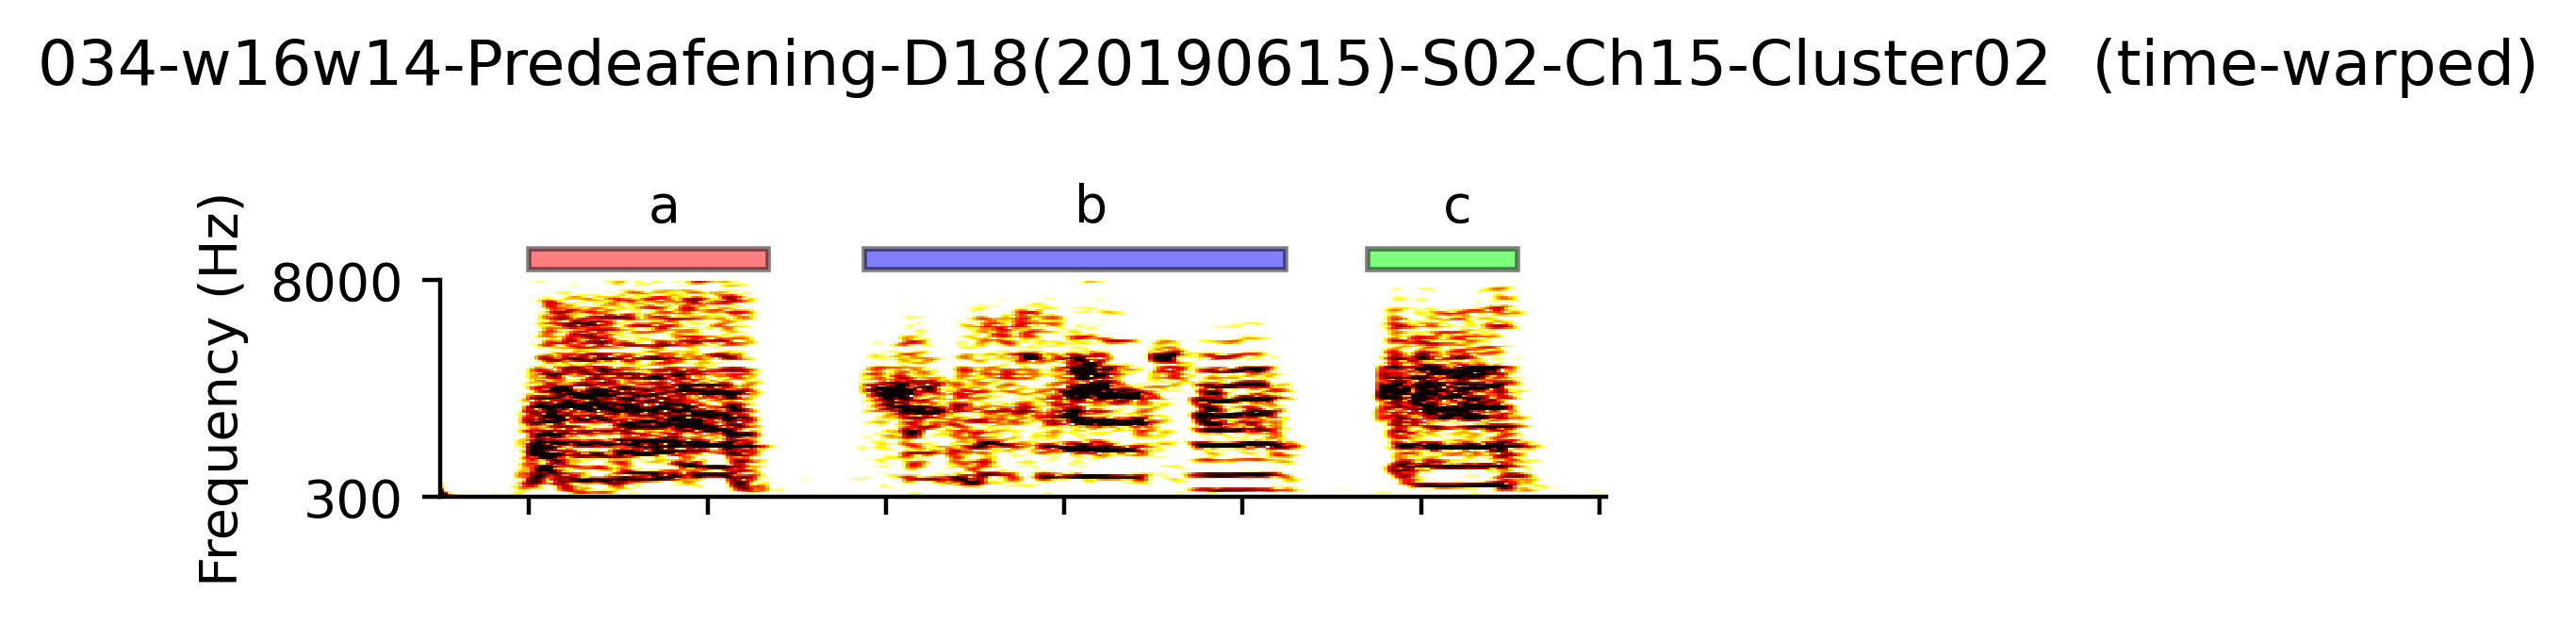

In [35]:
# Get spectrogram
timestamp, data = audio.extract([start, end])
spect_time, spect, spect_freq = audio.spectrogram(timestamp, data)

# Plot figure
fig = plt.figure(figsize=(6, 7), dpi=400)

fig.set_tight_layout(False)
if time_warp:
    fig_name = mi.name + '  (time-warped)'
else:
    fig_name = mi.name + '  (non-warped)'
plt.suptitle(fig_name, y=.93)
gs = gridspec.GridSpec(18, 6)
gs.update(wspace=0.025, hspace=0.05)

# Plot spectrogram
ax_spect = plt.subplot(gs[1:3, 0:4])
spect_time = spect_time - spect_time[0] - peth_parm['buffer']  # starts from zero
ax_spect.pcolormesh(spect_time, spect_freq, spect,
                    cmap='hot_r',
                    norm=colors.SymLogNorm(linthresh=0.05,
                                           linscale=0.03,
                                           vmin=0.5,
                                           vmax=100
                                           ))

remove_right_top(ax_spect)
ax_spect.set_xlim(-peth_parm['buffer'], duration + peth_parm['buffer'])
ax_spect.set_ylim(freq_range[0], freq_range[1])
ax_spect.set_ylabel('Frequency (Hz)', fontsize=font_size)
plt.yticks(freq_range, [str(freq_range[0]), str(freq_range[1])])
plt.setp(ax_spect.get_xticklabels(), visible=False)

# Plot syllable duration
ax_syl = plt.subplot(gs[0, 0:4], sharex=ax_spect)
note_dur = offsets - onsets  # syllable duration
onsets -= onsets[0]  # start from 0
offsets = onsets + note_dur

# Mark syllables
for i, syl in enumerate(mi.motif):
    rectangle = plt.Rectangle((onsets[i], rec_yloc), note_dur[i], 0.2,
                              linewidth=1, alpha=0.5, edgecolor='k', facecolor=note_color['Motif'][i])
    ax_syl.add_patch(rectangle)
    ax_syl.text((onsets[i] + (offsets[i] - onsets[i]) / 2), text_yloc, syl, size=font_size)
ax_syl.axis('off')
plt.show()

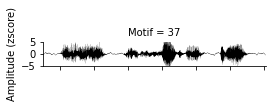

In [36]:
# Plot song amplitude
ax_amp = plt.subplot(gs[4:6, 0:4], sharex=ax_spect)
timestamp = timestamp - timestamp[0] - peth_parm['buffer']
data = stats.zscore(data)
ax_amp.plot(timestamp, data, 'k', lw=0.1)
ax_amp.set_ylabel('Amplitude (zscore)', fontsize=font_size)
ax_amp.set_ylim(-5, 5)
plt.setp(ax_amp.get_xticklabels(), visible=False)
ax_amp.set_title(f"Motif = {motif_nb}", fontsize=font_size)
remove_right_top(ax_amp)

In [37]:
mi.durations[motif_nb]

553.8999999999942

In [38]:
# Plot binarized song & firing rates
pi = mi.get_peth(time_warp=time_warp)  # peth object
pi.get_fr()  # get firing rates

ax_song = plt.subplot(gs[7:9, 0:4], sharex=ax_spect)

# Binarized song signal (0 = silence, 1 = song) Example from the first trial
song_ts = np.arange(-peth_parm['buffer'], round(mi.durations[0]) + peth_parm['buffer'], peth_parm['bin_size'])
binary_song = np.zeros(len(song_ts))
# binary_song[np.where(peth_parm['time_bin'] <= mi.durations[0])]
for onset, offset in zip(onsets, offsets):
    binary_song[np.where((song_ts >= onset) & (song_ts <= offset))] = 1
ax_song.plot(song_ts, binary_song, 'k',  linewidth=0.5)
ax_song.set_ylim([0, 1])
ax_song.set_yticks([])
ax_song.set_xlabel('Time (ms)', fontsize=font_size)
ax_song.spines['left'].set_visible(False)
ax_song.spines['top'].set_visible(False)
# Plot firing rates on the same axis
ax_fr = ax_song.twinx()
ax_fr.plot(pi.time_bin, pi.fr['All'][motif_nb, :], 'k')
ax_fr.set_ylabel('FR (Hz)', fontsize=font_size)
fr_ymax = myround(round(ax_fr.get_ylim()[1], 3), base=5)
ax_fr.set_ylim(0, fr_ymax)
plt.yticks([0, ax_fr.get_ylim()[1]], [str(0), str(int(fr_ymax))])
ax_fr.spines['left'].set_visible(False)
ax_fr.spines['top'].set_visible(False)

KeyError: 'nb_bins'

553.8999999999942

In [39]:
# Plot binarized song & firing rates
pi = mi.get_peth(time_warp=time_warp)  # peth object

KeyError: 'nb_bins'